# Synthetic Rotational Diagram
## February 2, 2022

This is a tutorial written by Alyssa Bulatek and Adam Ginsburg to demonstrate my rotational diagram fitting code on a synthetic spectrum generated with `pyspeckit`. It serves as a round-trip proof of concept of our rotational diagram fitting code, starting with a synthetic spectrum and a set temperature and column density, and retrieving the values from a fit to the data. [summary of tutorial, what molecule we use]

[To be submitted as an astropy or pyspeckit tutorial.]

### Imports and configuration

In [1]:
%matplotlib inline

## Step 1: Generate a fake spectral axis

We will begin by initializing the spectral axis we want to use for our synthetic spectrum, which will be between some minimum frequency `fmin` and maximum frequency `fmax`.

In [2]:
from astropy import units as u

fmin = 147.0*u.GHz
fmax = 147.2*u.GHz

In [3]:
import numpy as np

sp_axis = np.linspace(fmin, fmax, 1000)

## Step 2: Generate a synthetic spectrum

With our fake spectral axis, we can generate a synthetic spectrum. We will begin by defining some parameters for the spectrum, i.e. a filling factor and an offset. [should say what these mean]

In [4]:
fillingfactor = 1
offset = 0

Then, we'll define which molecular species we want to include in our synthetic spectrum. This could be expanded to include multiple species, but we'll just use methyl cyanide (CH3CN) for now.

In [5]:
species = 'CH3CN'

Now, we'll get the molecular parameters for this species from Splatalogue. All of the transitions for this molecule between `fmin` and `fmax` will be considered. As an output, the function `get_molecular_parameters` will give us the frequencies, Eistein *A* values, degrees of freedom, and upper-state energies for each of the transitions in the set frequency range, as well as the partition function for that molecule.

In [6]:
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from pyspeckit.spectrum.models import lte_molecule

freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = fmin, fmax = fmax)

We will now set several parameters that describe the source, so that they can be user-configurated. These values are the central velocity `v_cen`, the velocity dispersion `v_disp`, the temperature `temp`, and the total column density `N_tot`. [can include multiple velocity components]

In [7]:
v_cen = 50*u.km/u.s
v_disp = 1.5*u.km/u.s
temp = 100*u.K
N_tot = (10**(13.69))*u.cm**-2

Now we can generate model data that incorporates all of these transitions under the conditions we just set. The `generate_model` function takes as inputs the spectral axis we created earlier, several properties of the source (the central velocity, the velocity dispersion, the temperature, and the total column density), and the outputs from our query for molecular parameters. [want units—what are they?]

In [8]:
mod = lte_molecule.generate_model(sp_axis, v_cen, v_disp, temp, N_tot,
                                  freqs, aij, deg, EU, partfunc)

We can now build a `pyspeckit.Spectrum` object using this model data and the spectral axis we generated. We can plot this spectrum: it looks like a methyl cyanide ladder!

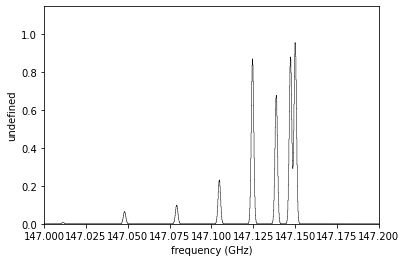

In [9]:
mod_sp = pyspeckit.Spectrum(xarr=sp_axis, data=mod)

mod_sp.plotter()

## Step 3: Measure (and convert) integrated intensities

Next, we'll prepare to build the rotational diagram by measuring the integrated intensities of each of the k-components of the spectrum. We will loop through each of the components, accessing the frequency, Einstein *A* value, and number of degrees of freedom for each component that we retrieved earlier. In the loop, we'll sum up the signal within some set velocity range of the center of each component, and then use the `nupper_of_kkms` function to convert the integrated intensity to an upper state column density.

In [10]:
# import warnings
# warnings.simplefilter('ignore')

7
6
5
4
3
2
1
0


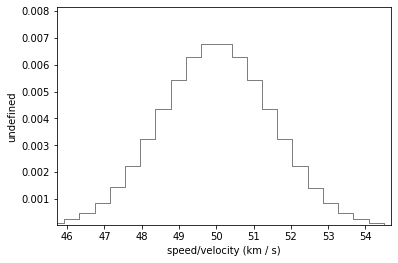

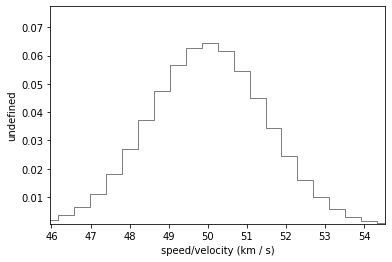

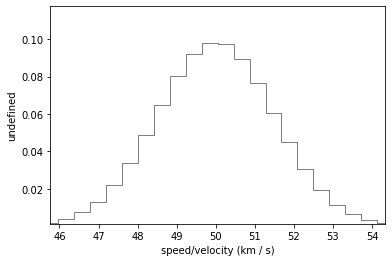

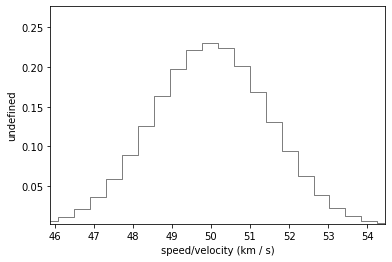

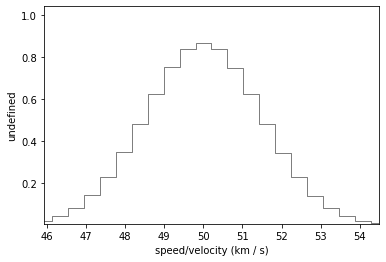

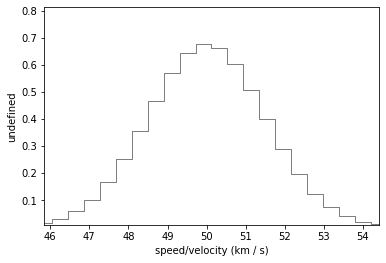

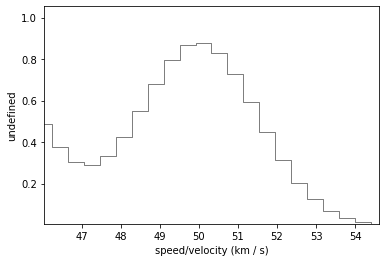

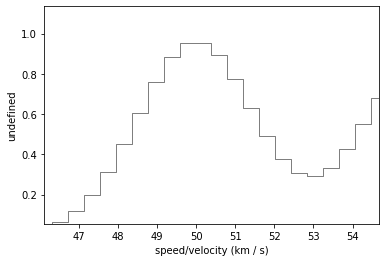

In [18]:
import pylab as pl
from pyspeckit.spectrum.models.lte_molecule import nupper_of_kkms

log_N_upper_gs = []

for freq, AA, gg in zip(freqs, aij, deg): # Loop goes low to high freq, high to low rotational index
    # Recenter the model spectrum so the component in this iteration is at v = 0
    mod_sp.xarr.convert_to_unit(u.km/u.s, refX = freq, velocity_convention='radio')
    # Get spectral slice for this component, using the central velocity to recenter
    new_sp = mod_sp.slice(v_cen - 4.5*u.km/u.s, v_cen + 4.5*u.km/u.s)
    new_sp.plotter(figure = pl.figure())
    # Calculate integrated intensity (sum slice and multiply by channel width)
    slice_sum = new_sp.data.sum()*u.K
    channel_width = np.abs(new_sp.xarr.cdelt())
    mom0 = slice_sum*channel_width
    # Convert the original spectrum back to frequency units
    mod_sp.xarr.convert_to_unit(u.Hz)
    # Calculated upper state column density from integrated intensity, convert to logscale, and export
    N_upper = nupper_of_kkms(mom0, freq, 10**AA)
    
    log_N_upper_g = np.log10(N_upper.value/gg)
    log_N_upper_gs.append(log_N_upper_g)
    
log_N_upper_gs = np.array(log_N_upper_gs)

## Step 4: Fit the rotational diagram

Finally, we can take the upper state column density values we just calculated and fit a line to them.

In [12]:
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))

# Replace all NaNs with 0s
ln_N_upper_gs = np.nan_to_num(ln_N_upper_gs)

In [13]:
# Note to self: do not reverse EU; we are looping over frequency now, 
# and in temperature map, we were looping over k-component index
print("Energies:", EU)
print("Column densities:", ln_N_upper_gs)

Energies: [5.26838987e-14 3.98795720e-14 2.90402001e-14 2.01682662e-14
 1.32657764e-14 8.33429995e-15 5.37496915e-15 4.38845933e-15]
Column densities: [20.04222965 20.96822431 21.75356394 22.39548971 22.89299058 23.25105132
 23.60683946 23.75966167]


[plot these?]

Now we will perform a linear fit to these values. Based on how we define the `linear` function, the output of the fit will be the best-fit `slope` and the `intercept` of the line.

In [14]:
from scipy.optimize import curve_fit
from astropy import constants

def linear(x, m, b):
    return m*x + b

EU_converted = (EU*u.erg/constants.k_B).decompose() 
# Note to self: convert to K from ergs to do the fit, because in ergs, 
# these energies are small numbers, and that can makes the fit not work

popt, pcov = curve_fit(linear, EU_converted, ln_N_upper_gs)
slope, intercept = popt[0], popt[1]
print(popt)

[-1.03818678e-02  2.39611334e+01]


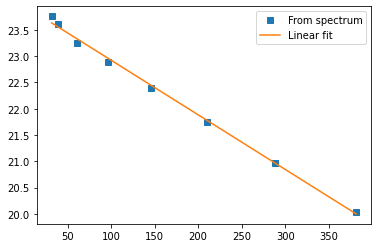

In [15]:
# import matplotlib.pyplot as plt
pl.plot(EU_converted, ln_N_upper_gs, 's', label = 'From spectrum')
pl.plot(EU_converted, EU_converted.value*slope+intercept, label = 'Linear fit')
pl.legend()

Now, we can print the temperature and column density values we derived from the fit and compare them to the values we initially put into the spectrum.

In [16]:
temp_fit = (-1./slope)*u.K
N_tot_fit = np.log10(np.exp(intercept)*partfunc(temp_fit))

print("Temperature (from fit):", temp_fit)
print("Temperature (original):", temp)
print("log10(Total column density) (from fit):", N_tot_fit)
print("log10(Total column density) (original):", np.log10(N_tot.value))

Temperature (from fit): 96.32178127804113 K
Temperature (original): 100.0 K
log10(Total column density) (from fit): 13.704955309222767
log10(Total column density) (original): 13.69
